In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import cv2
from os import listdir
from os.path import isfile, join

# imagens
PATH = 'C:\\Users\\marco\\Google Drive\\ComputerScience\\Visão Computacional\\images\\'

def getImagesFromFolder(folder_path):
    """
    Retorna todas as imagens .jpg com nomes na pasta.
    
    Return: list(tuple(fileName, img))
    """
    imgs_with_names = []
    for file in listdir(folder_path):    
        image_path = join(folder_path, file)
        if isfile(image_path) and file.endswith('.jpg'):
            # seleciona imagens .jpg
            img = plt.imread(image_path)
            imgs_with_names.append((file, img))
    return imgs_with_names

def SIFT(img):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return keypoints, descriptors

def matcher(descriptorsA, descriptorsB):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    best_matches = bf.match(descriptorsA, descriptorsB)
    raw_matches = sorted(best_matches, key=lambda x:x.distance)
    return raw_matches

def getHomography(kpsA, kpsB, descriptorsA, descriptorsB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None
    
    
def imgDiff(imgA, imgB, kernel=(5, 5)):
    kptsA, descA = SIFT(imgA)
    kptsB, descB = SIFT(imgB)
    
    matches = matcher(descB, descA)
    
    M = getHomography(kptsB, kptsA,
                  descB, descA,
                  matches, reprojThresh=4)
    (matches_, H, status_) = M
    
    width = imgA.shape[1]
    height = imgA.shape[0]
    imgB_transformed = cv2.warpPerspective(imgB, H, (width, height))
    
    imgA_gray = cv2.cvtColor(imgA, cv2.COLOR_RGB2GRAY)
    imgB_transformed_gray = cv2.cvtColor(imgB_transformed, cv2.COLOR_RGB2GRAY)
    
    imgA_smooth = cv2.GaussianBlur(imgA_gray, kernel, cv2.BORDER_DEFAULT)
    imgB_smooth = cv2.GaussianBlur(imgB_transformed_gray, kernel, cv2.BORDER_DEFAULT)
    
    img_diff = imgA_smooth - imgB_smooth
    return img_diff

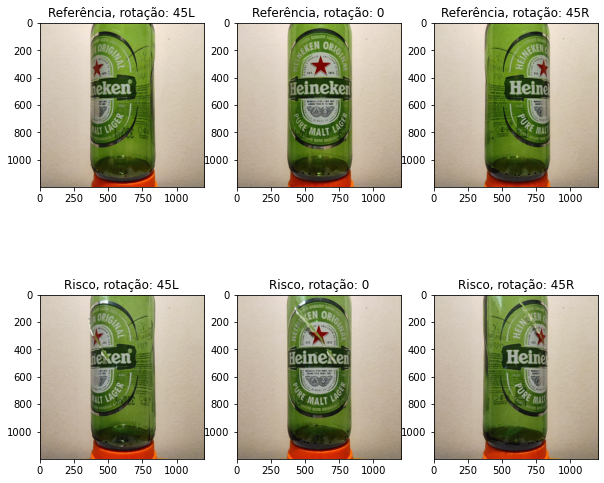

In [2]:
names = ['0\\0_v0_45L', '0\\0_v0_0', '0\\0_v0_45R', '1\\1_v0_45L', '1\\1_v0_0', '1\\1_v0_45R']
imgs = []
imgs_gray = []
for n in names:
    img = plt.imread(f'{PATH}\\{n}.jpg')
    imgs.append(img)
    imgs_gray.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
imgs = np.array(imgs)

nrow = 2
ncol = 3
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
for i in range(nrow):
    for j in range(ncol):
        axs[i, j].imshow(imgs[i * ncol + j])
        rotacao = names[i * ncol + j].split('_')[2]
        if names[i * ncol + j].find('0\\') != -1:
            # id = 0
            title = 'Referência, rotação: '
        else:
            # id = 1
            title = 'Risco, rotação: '
        axs[i, j].set_title(f'{title}{rotacao}')
plt.subplots_adjust(hspace=0)
plt.show()

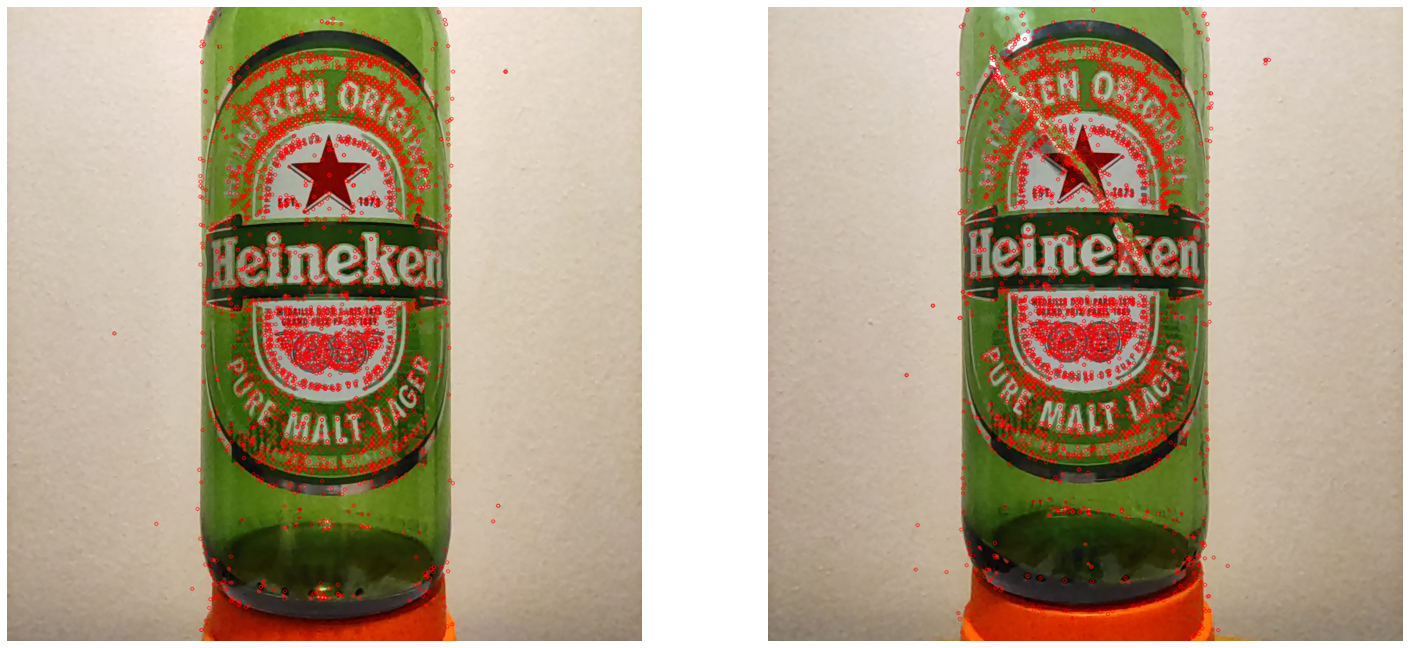

In [3]:
imgA = imgs[1]
imgB = imgs[4]

kptsA, descA = SIFT(imgA)
kptsB, descB = SIFT(imgB)

fig, axs = plt.subplots(1, 2, figsize=(25, 25))
axs[0].imshow(cv2.drawKeypoints(imgA, kptsA,
                               None, color=(255, 0, 0)))
axs[0].axis('off')
axs[1].imshow(cv2.drawKeypoints(imgB, kptsB,
                               None, color=(255, 0, 0)))
axs[1].axis('off')
plt.show()

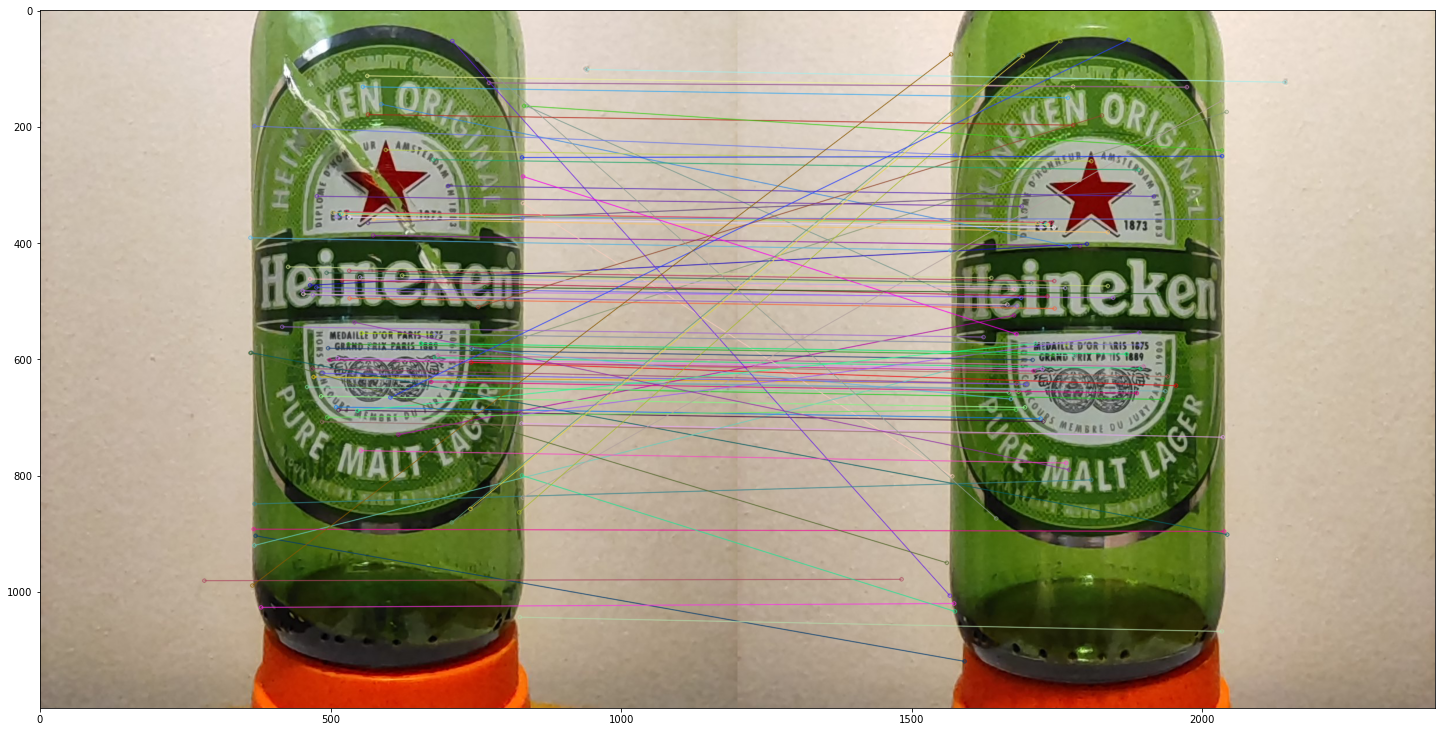

In [4]:
matches = matcher(descB, descA)
img_match = cv2.drawMatches(imgB, kptsB,
                            imgA, kptsA,
                            matches[:100], None,
                            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(25, 25))
plt.imshow(img_match)
plt.show()

In [5]:
M = getHomography(kptsB, kptsA,
                  descB, descA,
                  matches, reprojThresh=4)
(matches_, H, status_) = M
print(H)

[[ 1.01561652e+00 -1.04394700e-02  7.72901631e+00]
 [ 6.84441034e-03  9.93871005e-01  1.60671004e+01]
 [ 1.19939802e-05 -1.83680454e-05  1.00000000e+00]]


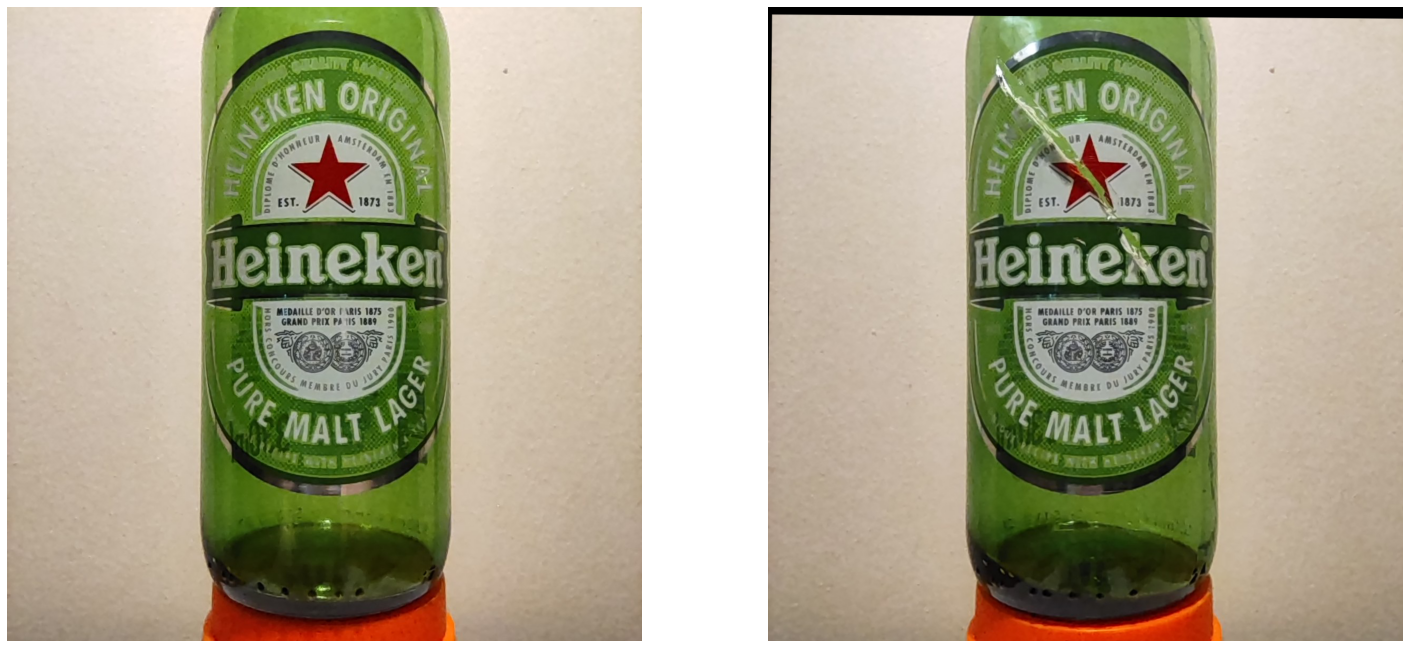

In [6]:
width = imgA.shape[1]
height = imgA.shape[0]
imgB_transformed = cv2.warpPerspective(imgB, H, (width, height))

fig, axs = plt.subplots(1, 2, figsize=(25, 25))
axs[0].imshow(imgA)
axs[0].axis('off')
axs[1].imshow(imgB_transformed)
axs[1].axis('off')
plt.show()

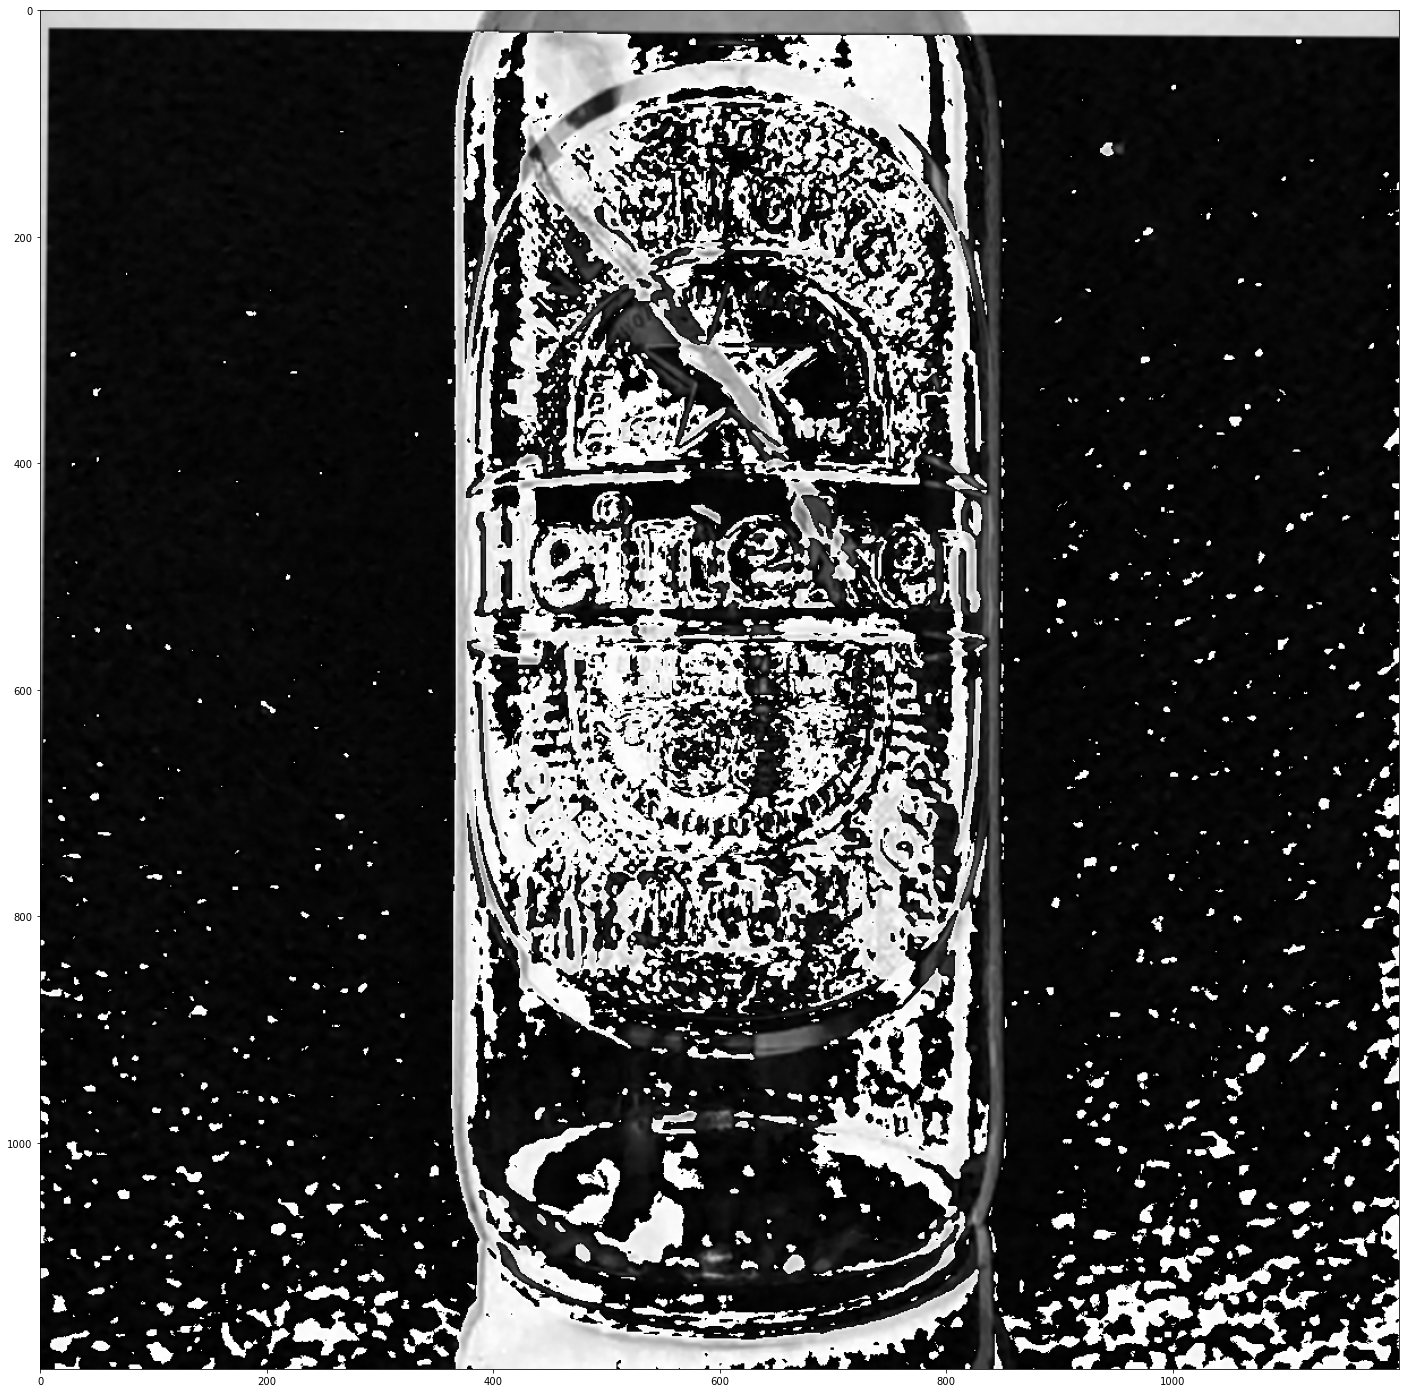

In [7]:
img_diff = imgDiff(imgA, imgB, (3, 3))

plt.figure(figsize=(25, 25))
plt.imshow(img_diff, 'gray')
plt.show()